<a href="https://colab.research.google.com/github/EyeofaThous/AAE590/blob/main/AAE590HW4tbranno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Two Point Correlation

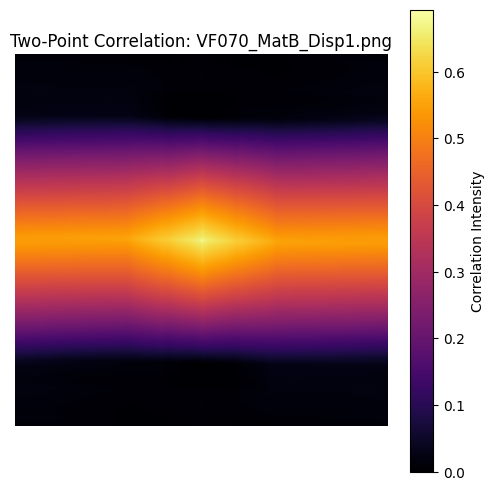

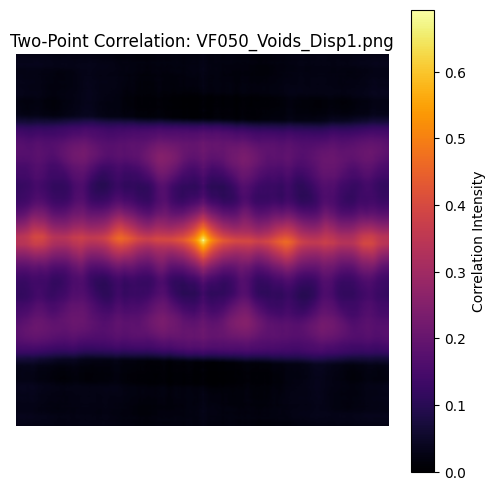

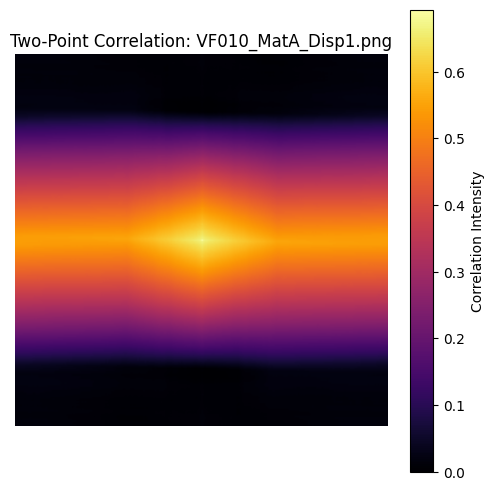

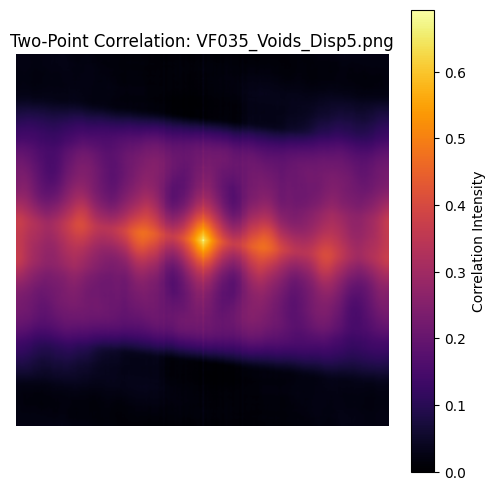

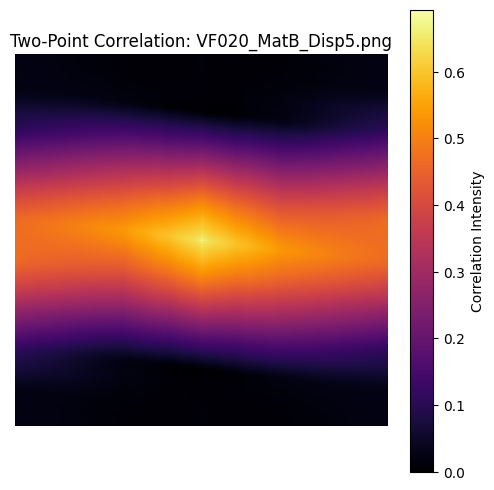

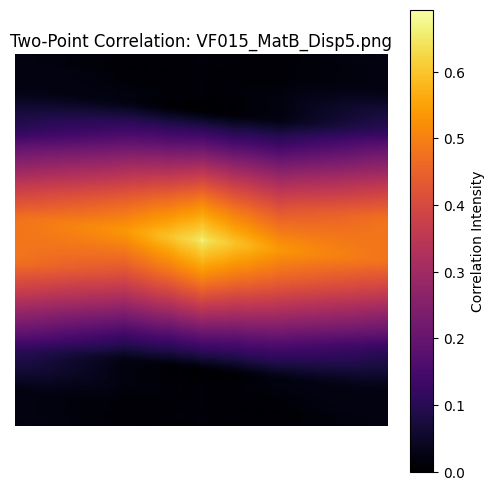

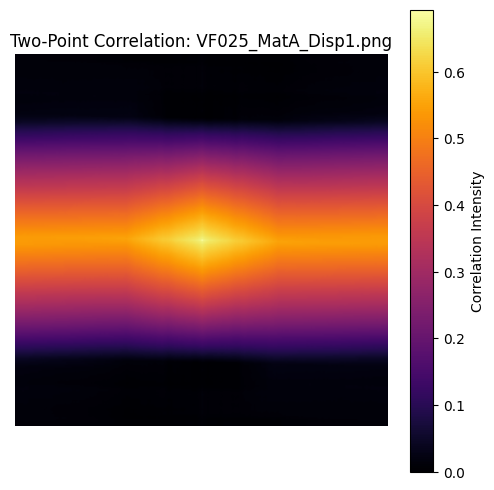

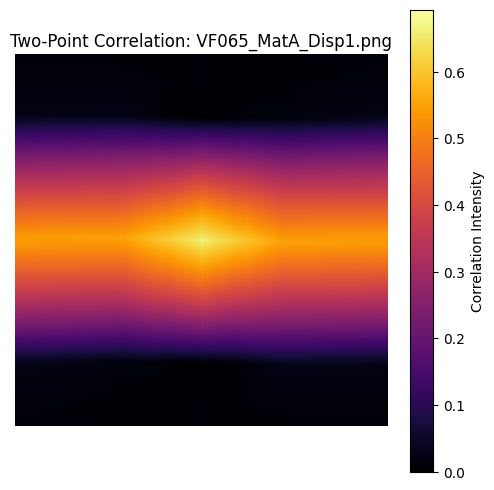

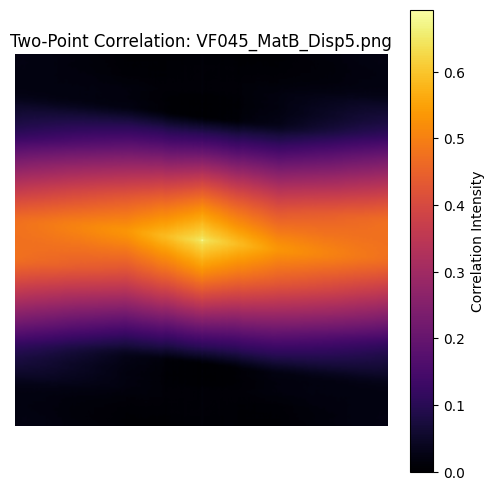

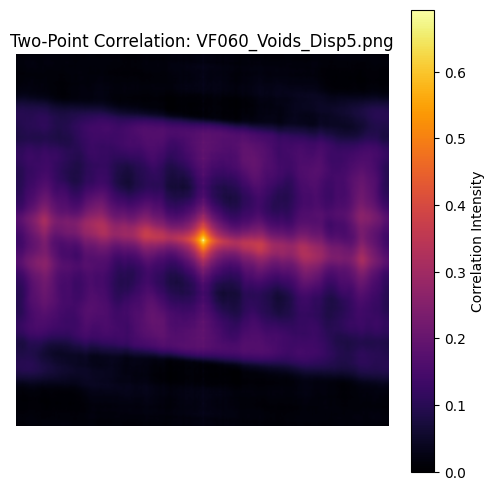

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from scipy.fftpack import fft2, ifft2, fftshift

def load_image(filepath, target_size=(256, 256)):
    """Load an image, convert to grayscale, and resize to a fixed size."""
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)  # Resize for consistency
    img = img.astype(np.float32) / 255.0  # Normalize intensity
    return img

def two_point_correlation(image):
    """Compute the two-point correlation function using FFT."""
    f = fft2(image)  # Forward FFT
    f_conj = np.conj(f)  # Complex conjugate
    correlation = ifft2(f * f_conj).real  # Inverse FFT to get correlation
    correlation = fftshift(correlation)  # Center the correlation

    # Normalize using min-max scaling
    correlation -= np.min(correlation)
    if np.max(correlation) != 0:
        correlation /= np.max(correlation)

    return correlation

# Load images dynamically
image_files = glob.glob("*.png")  # Adjust file path if needed
correlation_maps = []

for img_file in image_files:
    img = load_image(img_file, target_size=(256, 256))  # Ensure consistent size
    correlation = two_point_correlation(img)
    correlation_maps.append(correlation.flatten())  # Store for PCA later

    # Apply log scale for better contrast if needed
    log_correlation = np.log1p(correlation)

    # Plot each correlation separately
    plt.figure(figsize=(6, 6))
    plt.imshow(log_correlation, cmap="inferno", interpolation="bilinear")
    plt.title(f"Two-Point Correlation: {img_file}")
    plt.axis("off")
    plt.colorbar(label="Correlation Intensity")
    plt.show()

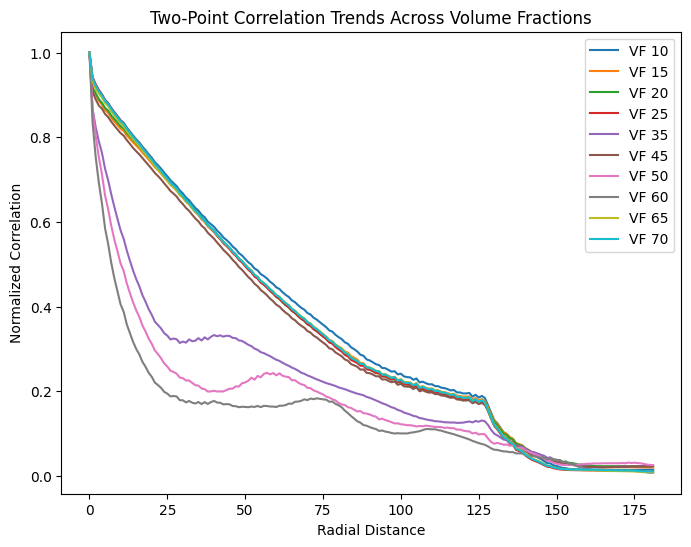

In [33]:
# Compute radial average of the correlation function
def radial_average(correlation):
    """Compute radial average of a 2D correlation map."""
    y, x = np.indices(correlation.shape)
    center = np.array(correlation.shape) // 2
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype(np.int32)

    tpc_profile = np.zeros(r.max() + 1)
    counts = np.zeros(r.max() + 1)

    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            ri = r[i, j]
            tpc_profile[ri] += correlation[i, j]
            counts[ri] += 1

    return tpc_profile / counts

# Load images dynamically and sort them by volume fraction (VFXX)
image_files = sorted(glob.glob("*.png"), key=extract_volume_fraction)
correlation_profiles = []
volume_fractions = []

for img_file in image_files:
    img = load_image(img_file, target_size=(256, 256))
    correlation = two_point_correlation(img)
    correlation_profile = radial_average(correlation)

    correlation_profiles.append(correlation_profile)

    # Extract VFXX value from filename
    vf_value = extract_volume_fraction(img_file)
    volume_fractions.append(vf_value)

# Convert to NumPy array
correlation_profiles = np.array(correlation_profiles)
volume_fractions = np.array(volume_fractions)

# Plot Two-Point Correlation Trends
plt.figure(figsize=(8, 6))
for i in range(len(correlation_profiles)):
    plt.plot(correlation_profiles[i], label=f"VF {volume_fractions[i]}")

plt.xlabel("Radial Distance")
plt.ylabel("Normalized Correlation")
plt.title("Two-Point Correlation Trends Across Volume Fractions")
plt.legend()
plt.show()

PCA

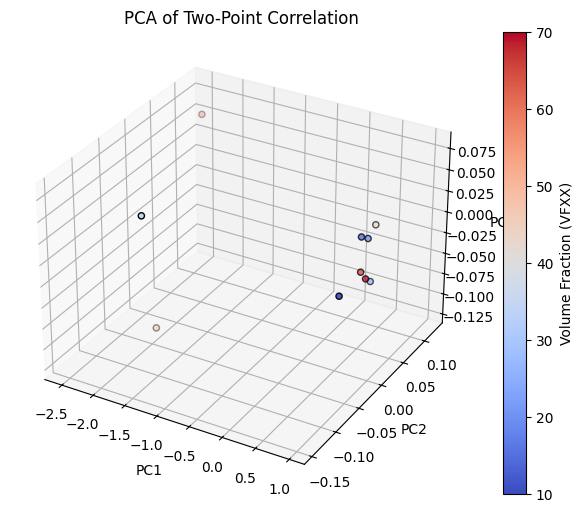

In [35]:
# Perform PCA on correlation profiles
pca = PCA(n_components=3)
pca_results = pca.fit_transform(correlation_profiles)

# Plot first three principal components (3D Scatter)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_results[:, 0], pca_results[:, 1], pca_results[:, 2], c=volume_fractions, cmap='coolwarm', edgecolor='k')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA of Two-Point Correlation")
plt.colorbar(sc, label="Volume Fraction (VFXX)")
plt.show()